In [1]:
import copy
import json
import os
import time
import torch

import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import open3d as o3d
import open3d.t.pipelines.registration as treg
import torch.nn as nn

from igraph import *
from tqdm.notebook import tqdm
from easydict import EasyDict as edict
from scipy.spatial.transform import Rotation

%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Вспомогательные функции

In [2]:
preprocess_time = []
transform_time = []

### Базовые функции

In [3]:
def visualize_pcd(ref_cloud, color=False):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(ref_cloud[:, :3])
    if color:
        pcd.colors = o3d.utility.Vector3dVector(ref_cloud[:, 3:] / 255)

    o3d.visualization.draw_plotly([pcd], width=800, height=600)


def draw_registration_result(source, target, transformation, title=None):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])

    source_temp.transform(transformation)

    if title is not None:
        print(title)

    o3d.visualization.draw_plotly([source_temp, target_temp])


def compare_grids(grid1, grid2, label1='Current grid', label2='Reference grid'):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    cmap = mpt.colors.ListedColormap(['white', 'gray', 'black'])

    axs[0].imshow(grid1, cmap=cmap)
    axs[0].set_title(label1)
    axs[0].grid(True, alpha=0.5, linestyle='-')

    axs[1].imshow(grid2, cmap=cmap)
    axs[1].set_title(label2)
    axs[1].grid(True, alpha=0.5, linestyle='-')

    fig.tight_layout()
    fig.show()


def visualize_iou(aligned_grid):
    plt.imshow(aligned_grid)
    plt.axis(False)
    plt.grid(True, alpha=0.5, linestyle='-')

    plt.show()


def make_pcd_from_array(array):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(array)

    return pcd

In [4]:
def remove_floor_and_ceil(cloud, floor_height=-0.9, ceil_height=1.5):
    heights = np.linspace(-4.0, 4.0, 41)
    floor_index = None
    if floor_height == 'auto':
        bins = []
        for i, height in enumerate(heights[:-1]):
            bins.append(len(cloud[(cloud[:, 2] > height) * (cloud[:, 2] < heights[i + 1])]))
        #print('Bins:', bins)
        floor_index = np.argmax(bins[:20]) + 1
        floor_height = heights[floor_index]
        assert floor_index < len(heights) - 5
    if ceil_height == 'auto':
        if floor_index is None:
            floor_index = 0
            while floor_index < len(heights) - 6 and heights[floor_index] < floor_height:
                floor_index += 1
        ceil_index = floor_index + 5 + np.argmax(bins[floor_index + 5:])
        ceil_height = heights[ceil_index]
    #print('Floor height:', floor_height)
    #print('Ceil height:', ceil_height)
    return cloud[(cloud[:, 2] > floor_height) * (cloud[:, 2] < ceil_height)]

In [5]:
def raycast(grid, n_rays=1000, center_point=None):
    grid_raycasted = grid.copy()
    if center_point is None:
        center_point = (grid.shape[0] // 2, grid.shape[1] // 2)
    resolution = 0.1
    radius = 8.0 / resolution
    for sector in range(n_rays):
        angle = sector / n_rays * 2 * np.pi - np.pi
        ii = center_point[0] + np.sin(angle) * np.arange(0, radius)
        jj = center_point[1] + np.cos(angle) * np.arange(0, radius)
        ii = ii.astype(int)
        jj = jj.astype(int)
        good_ids = ((ii > 0) * (ii < grid.shape[0]) ** (jj > 0) * (jj < grid.shape[1])).astype(bool)
        ii = ii[good_ids]
        jj = jj[good_ids]
        points_on_ray = grid[ii, jj]
        if len(points_on_ray.nonzero()[0]) > 0:
            last_obst = points_on_ray.nonzero()[0][-1]
            grid_raycasted[ii[:last_obst], jj[:last_obst]] = 1
        #else:
            #grid_raycasted[ii, jj] = 1
    return grid_raycasted

In [6]:
from scipy.ndimage import affine_transform

def transform_grid(grid, x, y, theta):
    shift_vector = np.array([x, y])
    rotation_matrix = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])

    center = np.array(grid.shape) / 2
    offset = center - rotation_matrix @ center
    offset += shift_vector

    grid_transformed = np.zeros(grid.size).reshape(grid.shape)
    grid_transformed = affine_transform(grid, rotation_matrix, offset=offset, order=0, mode='constant', cval=0)
    grid_transformed = grid_transformed.astype(np.uint8)
    return grid_transformed

def transform_pcd(cloud, x, y, theta):
    pcd_transformed = cloud.copy()  # эта функция нигде не вызывается, оставляем так
    return pcd_transformed

In [7]:
def get_occupancy_grid(points_xyz, resolution=0.1, radius=18, clip=8):
    index = np.isnan(points_xyz).any(axis=1)
    
    points_xyz = np.delete(points_xyz, index, axis=0)
    points_xyz = points_xyz[(points_xyz[:, 0] > -clip) * (points_xyz[:, 0] < clip) * \
                            (points_xyz[:, 1] > -clip) * (points_xyz[:, 1] < clip)]
    points_xyz_obstacles = remove_floor_and_ceil(points_xyz, floor_height=-0.3, ceil_height=0.5)

    #print('Points xyz:', points_xyz.shape, points_xyz[0], points_xyz.min(), points_xyz.max())
    grid = np.zeros((int(2 * radius / resolution), int(2 * radius / resolution)), dtype=np.uint8)
    points_ij = np.round(points_xyz[:, :2] / resolution).astype(int) + \
                        [int(radius / resolution), int(radius / resolution)]
    points_ij = points_ij[(points_ij[:, 0] >= 0) * (points_ij[:, 0] < grid.shape[0]) * \
                          (points_ij[:, 1] >= 0) * (points_ij[:, 1] < grid.shape[1])]
    
    grid[points_ij[:, 0], points_ij[:, 1]] = 1
    grid = raycast(grid)
    
    points_ij = np.round(points_xyz_obstacles[:, :2] / resolution).astype(int) + \
                [int(radius / resolution), int(radius / resolution)]
    points_ij = points_ij[(points_ij[:, 0] >= 0) * (points_ij[:, 0] < grid.shape[0]) * \
                          (points_ij[:, 1] >= 0) * (points_ij[:, 1] < grid.shape[1])]
    
    grid[points_ij[:, 0], points_ij[:, 1]] = 2
    return grid

In [8]:
def get_iou_of_grids(rel_x, rel_y, rel_theta, cur_grid, v_grid, visualize, save=False, cnt=0):
    rel_x_rotated = -rel_x * np.cos(rel_theta) - rel_y * np.sin(rel_theta)
    rel_y_rotated = rel_x * np.sin(rel_theta) - rel_y * np.cos(rel_theta)
    rel_x, rel_y = rel_x_rotated, rel_y_rotated
    
    cur_grid_transformed = transform_grid(cur_grid, rel_x, rel_y, rel_theta)
    cur_grid_transformed[cur_grid_transformed > 0] = 1
    
    v_grid_copy = v_grid.copy()
    v_grid_copy[v_grid_copy > 0] = 1
    
    intersection = np.sum(v_grid_copy * cur_grid_transformed)
    union = np.sum(v_grid_copy | cur_grid_transformed)

    grid_aligned = np.zeros((v_grid.shape[0], v_grid.shape[1], 3))
    grid_aligned[:, :, 0] = cur_grid_transformed
    grid_aligned[:, :, 1] = v_grid
    grid_aligned = (grid_aligned * 255).astype(np.uint8)
    
    if visualize:
        visualize_iou(grid_aligned)

    return intersection / union

In [9]:
def get_iou(rel_x, rel_y, rel_theta, cur_cloud, v_cloud, visualize=False):
    cur_grid = get_occupancy_grid(cur_cloud)
    v_grid = get_occupancy_grid(v_cloud)

    try:
        return get_iou_of_grids(rel_x, rel_y, rel_theta, cur_grid, v_grid, visualize)
    except ZeroDivisionError:
        return 0
    except Exception as e:
        print(e)
        return 0

In [10]:
def normalize(angle):
    while angle > np.pi:
        angle -= 2 * np.pi
    while angle < -np.pi:
        angle += 2 * np.pi
    return angle

def transformation_error(gt_pose_shift, tf_matrix_estimated):
    tf_rotation = Rotation.from_matrix(tf_matrix_estimated[:3, :3]).as_rotvec()
    gt_x, gt_y, gt_angle = gt_pose_shift
    #gt_angle = -gt_angle
    estimated_angle = tf_rotation[2]
    estimated_x = tf_matrix_estimated[0, 3]
    estimated_y = tf_matrix_estimated[1, 3]
    return (np.abs(estimated_x - gt_x), np.abs(estimated_y - gt_y), np.abs(normalize(estimated_angle - gt_angle)))

In [11]:
def get_rel_pose(x1, y1, theta1, x2, y2, theta2):
    return [x1 - x2, y1 - y2, theta1 - theta2]

### PointDSC

In [12]:
import sys

sys.path.insert(1, '/home/mavovk/TestTask')
sys.path.insert(1, '/home/mavovk/TestTask/PointDSC')

In [13]:
from PointDSC.models.PointDSC import PointDSC

In [14]:
chosen_snapshot = 'PointDSC_KITTI_release'

config_path = f'../PointDSC/snapshot/{chosen_snapshot}/config.json'
config = json.load(open(config_path, 'r'))
config = edict(config)

device = torch.device('cuda')

In [15]:
model = PointDSC(
    in_dim=config.in_dim,
    num_layers=config.num_layers,
    num_channels=config.num_channels,
    num_iterations=config.num_iterations,
    ratio=config.ratio,
    sigma_d=config.sigma_d,
    k=config.k,
    nms_radius=config.inlier_threshold,
).to(device)
miss = model.load_state_dict(torch.load(f'../PointDSC/snapshot/{chosen_snapshot}/models/model_best.pkl', map_location=device), strict=False)
model.eval()
print()

/tmp/ipykernel_4796/4222541985.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  miss = model.load_state_dict(torch.load(f'../PointDSC/snapshot/{chosen_snapshot}/models/m

In [16]:
def extract_fpfh_features(raw_pcd, downsample):
    global preprocess_time

    t0 = time.perf_counter()

    pcd = make_pcd_from_array(raw_pcd)

    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=downsample * 2, max_nn=30))
    keypts = pcd.voxel_down_sample(downsample)
    
    features = o3d.pipelines.registration.compute_fpfh_feature(keypts, o3d.geometry.KDTreeSearchParamHybrid(
        radius=downsample * 5, max_nn=100))
    features = np.array(features.data).T
    features = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-6)

    preprocess_time.append(time.perf_counter() - t0)
    return pcd, np.array(keypts.points), features

In [17]:
def get_point_dsc_transform(src_pts, src_features, tgt_pts, tgt_features):
    global transform_time

    t0 = time.perf_counter()

    distance = np.sqrt(2 - 2 * (src_features @ tgt_features.T) + 1e-6)
    source_idx = np.argmin(distance, axis=1)
    source_dis = np.min(distance, axis=1)
    corr = np.concatenate([np.arange(source_idx.shape[0])[:, None], source_idx[:, None]], axis=-1)
    src_keypts = src_pts[corr[:,0]]
    tgt_keypts = tgt_pts[corr[:,1]]
    corr_pos = np.concatenate([src_keypts, tgt_keypts], axis=-1)
    corr_pos = corr_pos - corr_pos.mean(0)

    # outlier rejection
    data = {
        'corr_pos': torch.from_numpy(corr_pos)[None].to(device).float(),
        'src_keypts': torch.from_numpy(src_keypts)[None].to(device).float(),
        'tgt_keypts': torch.from_numpy(tgt_keypts)[None].to(device).float(),
        'testing': True,
    }
    res = model(data)

    transform_time.append(time.perf_counter() - t0)

    return res['final_trans'][0].detach().cpu().numpy()

# Pipeline

## Registration

In [18]:
ious = []
dists = []
registration_results = []
calculated_dirs = []

In [19]:
# Change to the actual path to dataset
dataset_dir = '../data'
pr_data_dir = os.path.join(dataset_dir, 'place_recognition_data')
graph_data_dir = os.path.join(dataset_dir, 'graph_data')

In [20]:
data_dir = '../fastmac_data/PointDSC'
counter = 0

In [21]:
calculated_dirs = np.loadtxt(os.path.join(data_dir, 'tested_dirs.txt'))
calculated_dirs = list(calculated_dirs.astype(int))
registration_results = list(np.loadtxt(os.path.join(data_dir, 'result.txt')))
all_times = np.loadtxt(os.path.join(data_dir, 'mean_times.txt'))

/tmp/ipykernel_4796/1373360221.py:1: UserWarning: loadtxt: input contained no data: "../fastmac_data/PointDSC/tested_dirs.txt"
  calculated_dirs = np.loadtxt(os.path.join(data_dir, 'tested_dirs.txt'))
/tmp/ipykernel_4796/1373360221.py:3: UserWarning: loadtxt: input contained no data: "../fastmac_data/PointDSC/result.txt"
  registration_results = list(np.loadtxt(os.path.join(data_dir, 'result.txt')))
/tmp/ipykernel_4796/1373360221.py:4: UserWarning: loadtxt: input contained no data: "../fastmac_data/PointDSC/mean_times.txt"
  all_times = np.loadtxt(os.path.join(data_dir, 'mean_times.txt'))


In [22]:
for ii, test_name in tqdm(list(enumerate(os.listdir(pr_data_dir)))):
    if int(test_name) in calculated_dirs:
        continue

    test_dir = os.path.join(pr_data_dir, test_name)
    try:
        transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    except FileNotFoundError:
        continue

    if transforms_.size == 0:
        continue
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]

    cand_clouds = {}
    cand_poses = {}

    # Reference cloud (from robot)
    with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
        ref_cloud = CloudFile['arr_0']

    ref_cloud = ref_cloud[:, :3]
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))

    if transforms_.size == 0:
        pass

    for idx in transforms_[:, 0]:
        cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
        pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
        cand_clouds[int(idx)] = cloud
        cand_poses[int(idx)] = pose_stamped[1:]

    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))

    for i in range(transforms_.size // 7):
        idx = transforms_[i, 0]
        gt_pose = cand_poses[int(idx)]
        pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)

        # Candidate cloud (from graph of locations)
        cloud = cand_clouds[idx][:, :3]
        cloud = cloud[cloud == cloud].reshape((-1, 3))

        pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)
        dist = np.sqrt(pose_shift[0] ** 2 + pose_shift[1] ** 2)
        iou = get_iou(*pose_shift, ref_cloud, cloud, visualize=False)

        voxel_size = 0.2

        raw_src_pcd, src_pts, src_features = extract_fpfh_features(ref_cloud, voxel_size)
        raw_tgt_pcd, tgt_pts, tgt_features = extract_fpfh_features(cloud, voxel_size)

        transformation_matrix = get_point_dsc_transform(src_pts, src_features, tgt_pts, tgt_features)

        er = transformation_error(pose_shift, transformation_matrix)
        evaluation = o3d.pipelines.registration.evaluate_registration(make_pcd_from_array(ref_cloud), make_pcd_from_array(cloud), 0.9, transformation_matrix)
        registration_results.append([evaluation.fitness, *er, iou])
        all_times = np.append(all_times, [preprocess_time[-1], transform_time[-1]])

    calculated_dirs.append(test_name)
    np.savetxt(os.path.join(data_dir, 'tested_dirs.txt'), np.array(calculated_dirs), fmt='%s')
    np.savetxt(os.path.join(data_dir, 'result.txt'), np.array(registration_results))
    np.savetxt(
        os.path.join(data_dir, 'mean_times.txt'),
        all_times
    )

  0%|          | 0/1648 [00:00<?, ?it/s]

/tmp/ipykernel_4796/4039379099.py:7: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710495413820100000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_4796/4039379099.py:7: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710506453259492000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_4796/4039379099.py:7: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710504397952582000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_4796/4039379099.py:7: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710505116224765000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_4796/4039379099.py:7: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/

In [27]:
len(transform_time)

8025

In [31]:
all_times[::2].shape

(8025,)

In [32]:
all_times[1::2].shape

(8025,)

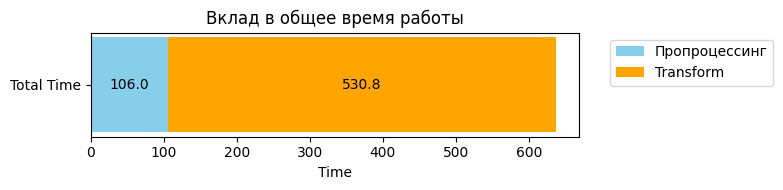

In [33]:
mean_times = [np.mean(all_times[::2]) * 1000, np.mean(all_times[1::2]) * 1000]
labels = ['Пропроцессинг', 'Transform']

total_time = sum(mean_times)

plt.figure(figsize=(8, 2))
bar_height = 0.8

plt.barh(['Total Time'], [mean_times[0]], height=bar_height, label=labels[0], color='skyblue')
plt.barh(['Total Time'], [mean_times[1]], height=bar_height, left=[mean_times[0]], label=labels[1], color='orange')
# plt.barh(['Total Time'], [mean_times[2]], height=bar_height, left=[mean_times[0] + mean_times[1]], label=labels[2], color='lightgreen')
# plt.barh(['Total Time'], [mean_times[3]], height=bar_height, left=[mean_times[0] + mean_times[1] + mean_times[2]], label=labels[3], color='purple')

for i, time in enumerate(mean_times):
    x_position = sum(mean_times[:i]) + time / 2
    plt.text(x_position, 0, f'{time:.1f}', ha='center', va='center', color='black', fontsize=10)

plt.xlabel('Time')
plt.title('Вклад в общее время работы')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

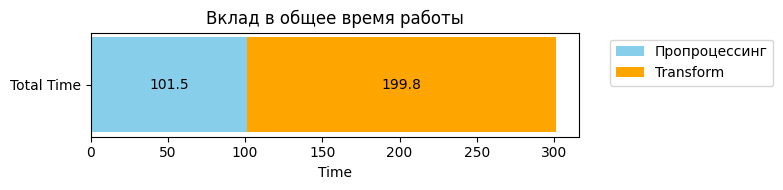

In [34]:
mean_times = [np.median(all_times[::2]) * 1000, np.median(all_times[1::2]) * 1000]
labels = ['Пропроцессинг', 'Transform']

total_time = sum(mean_times)

plt.figure(figsize=(8, 2))
bar_height = 0.8

plt.barh(['Total Time'], [mean_times[0]], height=bar_height, label=labels[0], color='skyblue')
plt.barh(['Total Time'], [mean_times[1]], height=bar_height, left=[mean_times[0]], label=labels[1], color='orange')
# plt.barh(['Total Time'], [mean_times[2]], height=bar_height, left=[mean_times[0] + mean_times[1]], label=labels[2], color='lightgreen')
# plt.barh(['Total Time'], [mean_times[3]], height=bar_height, left=[mean_times[0] + mean_times[1] + mean_times[2]], label=labels[3], color='purple')

for i, time in enumerate(mean_times):
    x_position = sum(mean_times[:i]) + time / 2
    plt.text(x_position, 0, f'{time:.1f}', ha='center', va='center', color='black', fontsize=10)

plt.xlabel('Time')
plt.title('Вклад в общее время работы')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [37]:
print(f"Среднее время работы: {(np.mean(all_times[::2]) + np.mean(all_times[1::2])) * 1000:.0f} мс")
print(f"Медианное время работы: {(np.median(all_times[::2]) + np.median(all_times[1::2])) * 1000:.0f} мс")

Среднее время работы: 637 мс
Медианное время работы: 301 мс


In [24]:
len(registration_results)

8025

In [42]:
ious = []
icp_results = []

for i in range(len(registration_results)):
    ious.append(registration_results[i][-1])
    icp_results.append(
        [registration_results[i][0],
        [registration_results[i][1], registration_results[i][2], registration_results[i][3]]]
    )

In [43]:
threshold = 0.7
print('Precision:', np.sum([(fitness > threshold) * (max(error) < 0.5) \
                                              for fitness, error in icp_results]) / \
                    np.sum([(fitness > threshold) for fitness, error in icp_results]))
print('Recall with IoU > 0.5:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(registration_results)) if ious[i] > 0.5]) / \
                                sum([i > 0.5 for i in ious]))
print('Recall with IoU > 0.25:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(registration_results)) if ious[i] > 0.25]) / \
                                sum([i > 0.25 for i in ious]))

Precision: 0.21199143468950749
Recall with IoU > 0.5: 0.3444857496902107
Recall with IoU > 0.25: 0.06485402273233787


In [42]:
pos = 0
errors = []
transforms = []

for root, dirs, files in os.walk(data_dir):
    if 'trans.txt' in files:
        trans_file_path = os.path.join(root, 'trans.txt')
        transforms.append(
            np.loadtxt(trans_file_path)
        )

In [55]:
for ii, test_name in tqdm(list(enumerate(os.listdir(pr_data_dir)))):
    test_dir = os.path.join(pr_data_dir, test_name)
    try:
        transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    except FileNotFoundError:
        continue

    if transforms_.size == 0:
        continue
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]

    cand_clouds = {}
    cand_poses = {}

    # Reference cloud (from robot)
    with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
        ref_cloud = CloudFile['arr_0']

    ref_cloud = ref_cloud[:, :3]
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))

    if transforms_.size == 0:
        pass

    for idx in transforms_[:, 0]:
        cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
        pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
        cand_clouds[int(idx)] = cloud
        cand_poses[int(idx)] = pose_stamped[1:]

    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))

    for i in range(transforms_.size // 7):
        if pos >= len(transforms):
            break

        if np.linalg.det(transforms[pos]) == 0:
            pos += 1
            continue

        idx = transforms_[i, 0]
        gt_pose = cand_poses[int(idx)]
        pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)
        iou = get_iou(*pose_shift, ref_cloud, cloud, visualize=False)

        er = transformation_error(pose_shift, np.linalg.inv(transforms[pos]))
        errors.append([iou, er])
        pos += 1

  0%|          | 0/1648 [00:00<?, ?it/s]

/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710495413820100000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710506453259492000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710504397952582000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710505116224765000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_39733/1622821447.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_

In [56]:
sum([(max(el[1]) < 0.5) for el in errors])

0

In [ ]:
threshold = 0.7
# print('Precision:', np.sum([(fitness > threshold) * (max(error) < 0.5) \
#                                               for fitness, error in icp_results]) / \
#                     np.sum([(fitness > threshold) for fitness, error in icp_results]))
print('Recall with IoU > 0.5:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(155) if ious[i] > 0.5]) / \
                                sum([i > 0.5 for i in ious]))
print('Recall with IoU > 0.25:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(155) if ious[i] > 0.25]) / \
                                sum([i > 0.25 for i in ious]))